<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [65]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import datetime
from datetime import datetime 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyClassifier
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
nltk.download('averaged_perceptron_tagger')
from sklearn.svm import LinearSVC
import numpy
import seaborn
import matplotlib.pyplot as plot
import math
from math import log
from sklearn.cluster import KMeans

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [66]:
# Loads a data file from a provided file location.
def load_data(path):

    try:
        loaded_data = pd.read_csv(path)
        print(loaded_data)
    except:
        print('The required file does not exist!')    

    return loaded_data

In [67]:
train_data = load_data("IA3-train.csv")

      sentiment                                               text
0             0  @united who is in charge of making decisions o...
1             0  @united great decision making skills flight op...
2             0  @AmericanAir so what if I didn't have the fund...
3             0  @united My flying United is over...sorry. The ...
4             0  @united I believe just customer service. At la...
...         ...                                                ...
8995          1  @SouthwestAir your flight attendants are reall...
8996          1  @VirginAmerica Love the team running Gate E9 a...
8997          0  @SouthwestAir really shouldn't offer sweeps if...
8998          0  @united no HUMAN contact for 2 mths from @Amer...
8999          1  @JetBlue Landing! As usual great flight wiyh a...

[9000 rows x 2 columns]


In [68]:
val_data = load_data("IA3-dev.csv")

      sentiment                                               text
0             1  @JetBlue Then en route to the airport the rebo...
1             0  @JetBlue I’m going to miss a hugely important ...
2             0  @USAirways never flying you guys again. your c...
3             0  @AmericanAir but, what I can always rely on wh...
4             0  @JetBlue you really should be more proactive w...
...         ...                                                ...
2495          0  @united kind of unnerving to watch the guy dei...
2496          0  @united already did that at the airport and 12...
2497          0  @JetBlue and they are telling me I got to get ...
2498          0  @USAirways delayed 2 days for weather and on t...
2499          0  @SouthwestAir We've been sitting at the gate f...

[2500 rows x 2 columns]


In [69]:
import numpy as np

# Loads GloVe embeddings from a designated file location. 
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find nearest neighbors via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7
    
    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    # 
    # If indicate_unk is set to True, the return type will be a tuple of 
    # (numpy array, bool) with the bool indicating whether the returned 
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)
    
    # Finds the vocab words associated with the k nearest embeddings of the provided word. 
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its 
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

In [70]:
ge = GloVe_Embedder("GloVe_Embedder_data.txt")

In [71]:
list_of_words = ['flight', 'good', 'terrible', 'help' , 'late']

In [72]:
embeds = ge.embed_list(list_of_words)

In [73]:
print(embeds.shape)

(5, 200)


In [74]:
word = 'flight'

In [75]:
embed = ge.embed_str(word)

In [76]:
embed

array([-1.6572e-01, -8.3950e-02,  2.2570e-02,  3.9720e-02,  3.0814e-01,
        1.7639e-01,  2.8357e-01,  5.5700e-03, -9.5600e-03,  1.4846e-01,
        4.8067e-01,  2.5237e-01, -4.3009e-01,  1.6862e-01,  1.2911e-01,
       -5.9924e-01, -1.3999e-01,  4.9635e-01, -8.2510e-02, -2.6530e-01,
       -2.1277e-01, -2.2453e-01,  3.0011e-01, -2.8075e-01,  5.1310e-02,
        1.0421e+00, -6.7080e-02, -5.7052e-01,  8.7370e-02, -4.3915e-01,
       -8.1000e-03,  5.2400e-03,  2.6832e-01, -6.5057e-01, -6.3500e-02,
        6.0998e-01, -7.6290e-01,  1.5033e-01,  9.2465e-01,  1.2769e-01,
       -3.1095e-01,  2.4462e-01,  9.2752e-01, -9.8065e-01,  3.0698e-01,
       -9.4610e-01, -1.6245e-01, -2.9793e-01,  4.7237e-01,  3.2092e-01,
       -2.7117e-01, -4.8036e-01,  1.8380e-02, -1.4158e-01, -3.4337e-01,
        1.1486e-01,  2.1472e-01,  7.0729e-01, -2.4157e-01, -2.1553e-01,
        3.9954e-01,  4.6465e-01,  4.1700e-01,  2.0390e-01, -3.0071e-01,
        1.1968e-01,  2.6760e-01,  1.3740e-02,  3.3544e-01, -8.09

In [77]:
nearest_list = []
for word in embeds:
    nearest_list.append(ge.find_k_nearest(word, 30))

In [78]:
nearest_list

[[['flight', 0.0],
  ['plane', 4.45689],
  ['flights', 5.32675],
  ['boarding', 5.4882],
  ['airline', 5.58355],
  ['jet', 5.59065],
  ['flying', 5.59299],
  ['heading', 5.6417],
  ['arrival', 5.70659],
  ['airlines', 5.85213],
  ['travel', 5.89098],
  ['shuttle', 5.90023],
  ['delayed', 5.91624],
  ['landing', 5.92666],
  ['route', 5.96298],
  ['airplane', 6.00258],
  ['safe', 6.00877],
  ['booking', 6.01374],
  ['fly', 6.02409],
  ['departure', 6.04052],
  ['waiting', 6.04259],
  ['landed', 6.09697],
  ['journey', 6.12156],
  ['passengers', 6.12345],
  ['transit', 6.12451],
  ['delay', 6.13663],
  ['crew', 6.14757],
  ['pilot', 6.17311],
  ['trip', 6.18669],
  ['taxi', 6.20436]],
 [['good', 0.0],
  ['great', 3.64107],
  ['well', 3.96383],
  ['nice', 4.00469],
  ['better', 4.19665],
  ['night', 4.30113],
  ['bad', 4.34788],
  ['morning', 4.43596],
  ['way', 4.52146],
  ['hope', 4.54451],
  ['but', 4.55671],
  ['too', 4.57775],
  ['really', 4.60558],
  ['right', 4.68877],
  ['though', 

In [79]:
len(nearest_list)

5

In [80]:
nearest_array = np.asarray(nearest_list)

In [81]:
nearest_array

array([[['flight', '0.0'],
        ['plane', '4.45689'],
        ['flights', '5.32675'],
        ['boarding', '5.4882'],
        ['airline', '5.58355'],
        ['jet', '5.59065'],
        ['flying', '5.59299'],
        ['heading', '5.6417'],
        ['arrival', '5.70659'],
        ['airlines', '5.85213'],
        ['travel', '5.89098'],
        ['shuttle', '5.90023'],
        ['delayed', '5.91624'],
        ['landing', '5.92666'],
        ['route', '5.96298'],
        ['airplane', '6.00258'],
        ['safe', '6.00877'],
        ['booking', '6.01374'],
        ['fly', '6.02409'],
        ['departure', '6.04052'],
        ['waiting', '6.04259'],
        ['landed', '6.09697'],
        ['journey', '6.12156'],
        ['passengers', '6.12345'],
        ['transit', '6.12451'],
        ['delay', '6.13663'],
        ['crew', '6.14757'],
        ['pilot', '6.17311'],
        ['trip', '6.18669'],
        ['taxi', '6.20436']],

       [['good', '0.0'],
        ['great', '3.64107'],
        ['wel

In [82]:
nearest_array = nearest_array.flatten()

In [83]:
filtered_list = list(filter(lambda x: (x.isalpha()), nearest_array))

In [84]:
filtered_list_of_numbers = [float(x) for x in list(filter(lambda x: (not x.isalpha()), nearest_array))]

In [85]:
filtered_list_of_numbers

[0.0,
 4.45689,
 5.32675,
 5.4882,
 5.58355,
 5.59065,
 5.59299,
 5.6417,
 5.70659,
 5.85213,
 5.89098,
 5.90023,
 5.91624,
 5.92666,
 5.96298,
 6.00258,
 6.00877,
 6.01374,
 6.02409,
 6.04052,
 6.04259,
 6.09697,
 6.12156,
 6.12345,
 6.12451,
 6.13663,
 6.14757,
 6.17311,
 6.18669,
 6.20436,
 0.0,
 3.64107,
 3.96383,
 4.00469,
 4.19665,
 4.30113,
 4.34788,
 4.43596,
 4.52146,
 4.54451,
 4.55671,
 4.57775,
 4.60558,
 4.68877,
 4.69955,
 4.70148,
 4.70444,
 4.7177,
 4.76147,
 4.76949,
 4.78543,
 4.81795,
 4.83542,
 4.84457,
 4.85276,
 4.86179,
 4.89081,
 4.9018,
 4.90492,
 4.90592,
 0.0,
 2.8716,
 4.31316,
 5.24022,
 5.35858,
 5.45579,
 5.49845,
 5.56903,
 5.58304,
 5.59716,
 5.631,
 5.64538,
 5.67322,
 5.71411,
 5.73043,
 5.73712,
 5.78009,
 5.78166,
 5.80851,
 5.82791,
 5.86491,
 5.87343,
 5.88777,
 5.89628,
 5.9003,
 5.90768,
 5.93984,
 5.94033,
 5.97906,
 5.98936,
 0.0,
 4.66871,
 4.71355,
 4.8564,
 5.26437,
 5.27073,
 5.33329,
 5.35559,
 5.3827,
 5.39777,
 5.40568,
 5.42209,
 5.547

In [86]:
len(filtered_list)

150

In [87]:
filtered_list

['flight',
 'plane',
 'flights',
 'boarding',
 'airline',
 'jet',
 'flying',
 'heading',
 'arrival',
 'airlines',
 'travel',
 'shuttle',
 'delayed',
 'landing',
 'route',
 'airplane',
 'safe',
 'booking',
 'fly',
 'departure',
 'waiting',
 'landed',
 'journey',
 'passengers',
 'transit',
 'delay',
 'crew',
 'pilot',
 'trip',
 'taxi',
 'good',
 'great',
 'well',
 'nice',
 'better',
 'night',
 'bad',
 'morning',
 'way',
 'hope',
 'but',
 'too',
 'really',
 'right',
 'though',
 'there',
 'day',
 'luck',
 'sure',
 'it',
 'thing',
 'pretty',
 'think',
 'have',
 'all',
 'yes',
 'very',
 'again',
 'work',
 'yeah',
 'terrible',
 'horrible',
 'awful',
 'bad',
 'brutal',
 'idea',
 'horrendous',
 'horrid',
 'shitty',
 'quite',
 'worst',
 'similar',
 'shame',
 'worse',
 'crap',
 'actual',
 'horrific',
 'bloody',
 'ridiculous',
 'such',
 'atrocious',
 'dreadful',
 'sick',
 'wtf',
 'fucking',
 'cruel',
 'seriously',
 'unreal',
 'mess',
 'however',
 'help',
 'need',
 'helping',
 'please',
 'pls',
 'l

In [88]:
filtered_embeds = ge.embed_list(filtered_list)

In [89]:
filtered_embeds.shape

(150, 200)

In [90]:
filtered_embeds

array([[-0.16572, -0.08395,  0.02257, ..., -0.28324,  0.45505,  0.14103],
       [-0.25592, -0.33874, -0.09671, ..., -0.55179,  0.38059,  0.03867],
       [-0.57264,  0.35847,  0.37772, ...,  0.24231,  0.39318,  0.93379],
       ...,
       [-0.25522,  0.0906 , -0.07389, ...,  0.14102,  0.28921,  0.4418 ],
       [ 0.18512,  0.01346, -0.12087, ...,  0.22114,  0.11646, -0.03482],
       [-0.26034,  0.26942,  0.16707, ..., -0.15519,  0.55632,  0.30085]])

In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
model_pca = pca.fit_transform(filtered_embeds)
pca_df = pd.DataFrame(data = model_pca, columns = ['col1', 'col2'])

In [92]:
pca_df.shape[0]

150

In [93]:
def plot_tsne(step):
    x = 0
    while x <= tsne_df.shape[0]:
        plt.scatter(tsne_df[x:x+30]['col1'], tsne_df[x:x+30]['col2'])
        plt.legend(labels = list_of_words)
        plt.xlabel('tsne_dimension_1')
        plt.ylabel('tsne_dimension_2')
        step = str(step)
        plt.title('Vsualizing 150 words into 2-d space in TSNE ' + 'perplexity value ' + step)
        x += 30

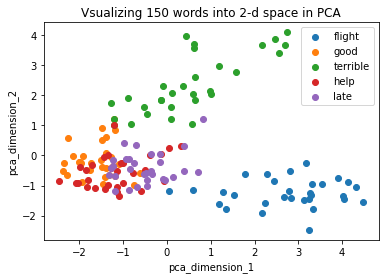

In [94]:
x = 0
while x <= pca_df.shape[0]:
    plt.scatter(pca_df[x:x+30]['col1'], pca_df[x:x+30]['col2'])
    plt.legend(labels = list_of_words)
    plt.xlabel('pca_dimension_1')
    plt.ylabel('pca_dimension_2')
    plt.title('Vsualizing 150 words into 2-d space in PCA')
    x += 30

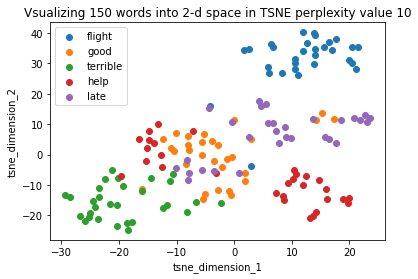

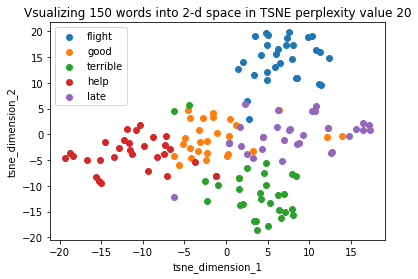

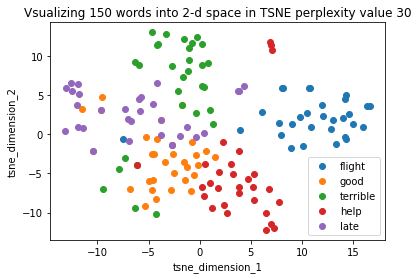

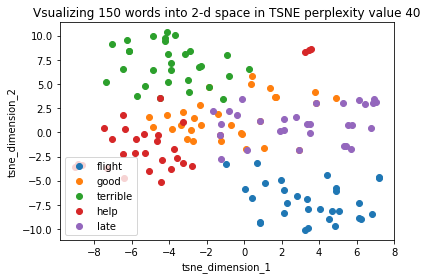

In [95]:
from sklearn.manifold import TSNE
for step in range(10, 50, 10):
    model_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=step).fit_transform(filtered_embeds)
    tsne_df = pd.DataFrame(data = model_tsne, columns = ['col1', 'col2'])
    plot_tsne(step)
    plt.show()

In [96]:
list_of_inertia = []
list_of_clusters = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_inertia.append(kmeans.inertia_)
    list_of_clusters.append(cluster)

Text(0.5, 1.0, 'Inertia Vs. K-values')

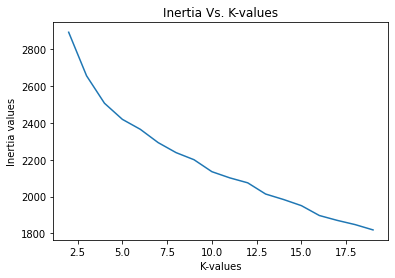

In [97]:
plt.plot(list_of_clusters, list_of_inertia)
plt.ylabel('Inertia values')
plt.xlabel('K-values')
plt.title('Inertia Vs. K-values')

In [98]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [99]:
filtered_embeds

array([[-0.16572, -0.08395,  0.02257, ..., -0.28324,  0.45505,  0.14103],
       [-0.25592, -0.33874, -0.09671, ..., -0.55179,  0.38059,  0.03867],
       [-0.57264,  0.35847,  0.37772, ...,  0.24231,  0.39318,  0.93379],
       ...,
       [-0.25522,  0.0906 , -0.07389, ...,  0.14102,  0.28921,  0.4418 ],
       [ 0.18512,  0.01346, -0.12087, ...,  0.22114,  0.11646, -0.03482],
       [-0.26034,  0.26942,  0.16707, ..., -0.15519,  0.55632,  0.30085]])

In [100]:
from numpy import random

x=random.randint(150, size=(5))

In [101]:
xyz = [0,1,2,3,4]

In [102]:
true_labels = [27, 54, 87, 112, 145]

In [103]:
words = []
for value in true_labels:
    words.append(filtered_list[value])

In [104]:
words

['pilot', 'all', 'unreal', 'want', 'wake']

In [105]:
kmeans_embeds = ge.embed_list(words)

In [106]:
kmeans_embeds.shape

(5, 200)

In [107]:
# weights_of_words = np.asarray(weights_of_words)
# weights_of_words = weights_of_words.reshape(-1, 1)

In [108]:
new_array = []
x = 150
i = 0
while x >0:
    d = [i]* 30
    new_array+=d
    x -= 30
    i += 1

In [109]:
new_array

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [110]:
from sklearn.metrics.cluster import adjusted_rand_score
list_of_predictions = []
list_of_labels = []
cluster_centers = []
cluster_size = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_labels.append(kmeans.labels_)
    cluster_centers.append(kmeans.cluster_centers_)
   # kmeans_prediction = kmeans.predict(kmeans_embeds)
    kmeans_prediction = kmeans.predict(filtered_embeds)
    
    print('f cluster: {}'.format(cluster), normalized_mutual_info_score(new_array, kmeans_prediction))
    list_of_predictions.append(normalized_mutual_info_score(new_array, kmeans_prediction))
    cluster_size.append(cluster)

f cluster: 2 0.3601051520996533
f cluster: 3 0.6138981869527641
f cluster: 4 0.6410376946767983
f cluster: 5 0.7094382303217028
f cluster: 6 0.6292536722906626
f cluster: 7 0.682911927834081
f cluster: 8 0.6388489415826499
f cluster: 9 0.5783991425965873
f cluster: 10 0.559444573465042
f cluster: 11 0.5821611154070353
f cluster: 12 0.5688651317457399
f cluster: 13 0.6065932244105091
f cluster: 14 0.5624987464308063
f cluster: 15 0.6017181091613001
f cluster: 16 0.5382331889745171
f cluster: 17 0.5499027161807599
f cluster: 18 0.5152653171458719
f cluster: 19 0.5415851665019153


Text(0.5, 1.0, 'Graph of Mutual Information vs Clusters')

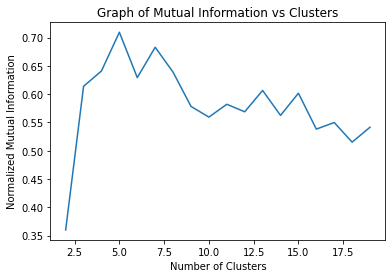

In [131]:
plt.plot( cluster_size, list_of_predictions)
plt.xlabel('Number of Clusters')
plt.ylabel('Normalized Mutual Information')
plt.title('Graph of Mutual Information vs Clusters')

In [112]:
list_of_predictions_adj = []
cluster_size_adj = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_labels.append(kmeans.labels_)
    cluster_centers.append(kmeans.cluster_centers_)
   # kmeans_prediction = kmeans.predict(kmeans_embeds)
    kmeans_prediction = kmeans.predict(filtered_embeds)
    
    print('f cluster: {}'.format(cluster), adjusted_rand_score(new_array, kmeans_prediction))
    list_of_predictions_adj.append(adjusted_rand_score(new_array, kmeans_prediction))
    cluster_size_adj.append(cluster)

f cluster: 2 0.1722357081181473
f cluster: 3 0.38110777201023993
f cluster: 4 0.4780653619861524
f cluster: 5 0.6068964244861813
f cluster: 6 0.4330101409403741
f cluster: 7 0.5970798321046645
f cluster: 8 0.47887643661249507
f cluster: 9 0.4068599112396771
f cluster: 10 0.360002445391908
f cluster: 11 0.37713513377800467
f cluster: 12 0.3823853849352148
f cluster: 13 0.3918508303299301
f cluster: 14 0.3009452245354132
f cluster: 15 0.4268139402018663
f cluster: 16 0.28672153347224927
f cluster: 17 0.30809463290644246
f cluster: 18 0.25395239051828045
f cluster: 19 0.25702441038004625


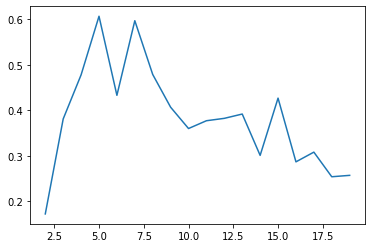

In [113]:
plt.plot( cluster_size_adj, list_of_predictions_adj)
plt.xlabel('Number of Clusters')
plt.ylabel('Normalized Mutual Information')
plt.title('Graph of Mutual Information vs Clusters')

In [129]:
from sklearn.metrics.cluster import contingency_matrix
list_of_predictions_purity = []
cluster_size_purity = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_labels.append(kmeans.labels_)
    cluster_centers.append(kmeans.cluster_centers_)
   # kmeans_prediction = kmeans.predict(kmeans_embeds)
    kmeans_prediction = kmeans.predict(filtered_embeds)
    cont_matrix = contingency_matrix(new_array, kmeans_prediction)
    purity = np.sum(np.amax(cont_matrix, axis=0)) / np.sum(cont_matrix)
    print('f cluster: {}'.format(cluster), purity)
    list_of_predictions_purity.append(purity)
    cluster_size_purity.append(cluster)

f cluster: 2 0.38666666666666666
f cluster: 3 0.5666666666666667
f cluster: 4 0.6933333333333334
f cluster: 5 0.8066666666666666
f cluster: 6 0.7533333333333333
f cluster: 7 0.8533333333333334
f cluster: 8 0.8266666666666667
f cluster: 9 0.7666666666666667
f cluster: 10 0.8066666666666666
f cluster: 11 0.76
f cluster: 12 0.7866666666666666
f cluster: 13 0.7866666666666666
f cluster: 14 0.7866666666666666
f cluster: 15 0.86
f cluster: 16 0.8
f cluster: 17 0.84
f cluster: 18 0.8066666666666666
f cluster: 19 0.8133333333333334


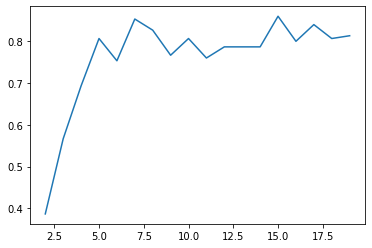

In [130]:
plt.plot(cluster_size_purity, list_of_predictions_purity)